# Build a polymer/liquid mixture geometry using EMC.
Copyright ENEOS Corporation as contributors to Matlantis contrib project

Enhanced Monte Carlo\
https://montecarlo.sourceforge.net/emc/Welcome.html \
https://matsci.org/c/emc/50

P.J. in 't Veld and G.C. Rutledge, Macromolecules 2003, 36, 7358

In this example, an amorphous polymer geometry is built using an package Enhanced Monte Calro (EMC), which is distributed under GPL v3 Lincense. 

## Import python packages

In [1]:
import os
import sys
import numpy as np

from ase import Atoms, units
from ase.io import read, write, Trajectory
from ase.data import atomic_masses
from ase.optimize import LBFGS

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

In [2]:
from pfcc_extras.visualize.view import view_ngl
from pfcc_extras.structure.ase_rdkit_converter import smiles_to_atoms, atoms_to_smiles
from pfcc_extras.structure.connectivity import get_connected_components
from matlantis_features.utils.calculators import pfp_estimator_fn, get_calculator

## Import a local package for executing EMC
EMC is a huge package which can be used to setup various kind of molecular simulations. 
For simplicity, this example provides thee templates of the input file of EMC: amorphous homopolymer, liquids, and a mixture of homopolymer and liquids. These templates are available through an wrapper package EMC_interface.

In [3]:
sys.path.insert(0, 'EMC_interface/src/emc_interface')
from emc_interface import EMCInterface

In [4]:
def set_elements_lammpsdata(atoms):
    mass_number = {int(np.round(m)):i for i, m in enumerate(atomic_masses)}
    masses = atoms.get_masses()
    numbers = [mass_number[int(np.round(m))] for m in masses] 
    atoms.numbers=numbers
    return atoms

## System settings

In [5]:
outputdir = './output'
os.makedirs(outputdir, exist_ok=True)

The polymer structure is defined by three SMILES strings, `smiles_center`, `smiles_left`, and `smiles_right`. The monomer unit is represented by `smiles_center` and both end of the chain are terminated by the moeclues represented by `smiles_left` and `smiles_right`. Asterisk `*` in the SMILES strings represents the connecting point of the monomer molecule.

The liquid structure is defined by SMILES strings with molecular fractions. `name_smiles_fractions` is a dictionary which stores the names of the components and the tuples of (SMILES, fraction) pairs as the keys and values, respectively.

In this example, the polymer chain consists of 10 momomers (8 central units terminated at both ends), and the liquid structure is composed of H$_{2}$0 and C$_{2}$H$_{5}$OH. The number of atoms in the system is more than 2,000 and the system density is set at 0.85 g/cm^3. The structure is created by Monte Carlo method using the PCFF force field.

In [6]:
name_smiles_fractions = {"water":("O", 1), 
"alcohol":("CCO", 1),
# "salt":("[Na+].[Cl-]", 5)
}

smiles_center = '*NCCCCCC(=O)*'
smiles_left = 'NCCCCCC(=O)*'
smiles_right = '*NCCCCCC(=O)O'

settings = dict(
            name_smiles_fractions = name_smiles_fractions,
            smiles_center = smiles_center,
            smiles_left = smiles_left,
            smiles_right = smiles_right,
            polymer_fraction=1,
            ntotal = 2000,   # Total number of atoms in the cell.
            density = 0.85,  # The mass density of the system [g/cm3]. Please use smaller value compared to the target density.
            field='pcff',    # The force field used in the Monte Carlo method.
            ring_depth = 9,  # Default to 'auto'. The max ring size in the molecules.
            build_dir = './build',
            lammps_prefix = 'mixture',  # Prefix for the input file of LAMMPS.
            project='mixture',          # Project name used in the input files of LAMMPS.
            seed=12345,       # Random seed for the Monte Carlo simulation.
            repeat_center=8,  # 10 monomers with center + left + right 
)

### Comfirm the molecular structures defined by the SMILES strings.

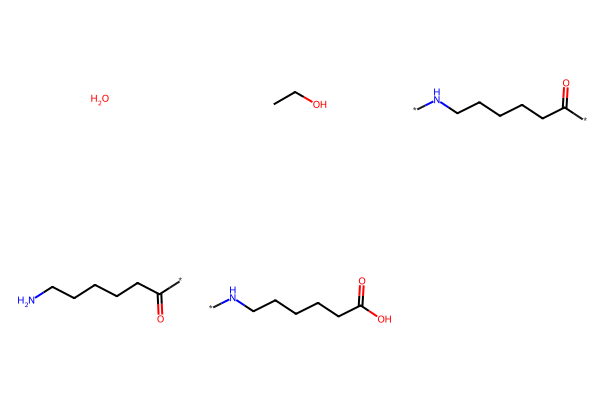

In [7]:
smileses = [s for n,(s,f) in name_smiles_fractions.items()]
smileses.extend([smiles_center, smiles_left, smiles_right])

mols = [Chem.MolFromSmiles(smiles) for smiles in smileses]
view = Draw.MolsToGridImage(mols)

display(view)

### Confirm the EMC settings and the structure of the mixture with a small number of atoms.

In [8]:
ntotal, settings['ntotal'] = settings['ntotal'], int(0.2 * settings['ntotal'])

builder = EMCInterface()
builder.verbose  =True
builder.setup('mixture', **settings)
builder.build()

basename =  f'{builder.settings["project"]}'
atoms = read(f'{basename}.pdb')
print(f'Number of atoms: {len(atoms)} (< {settings["ntotal"]})')
settings['ntotal'] = ntotal

view_ngl([atoms], ['ball+stick'], replace_structure=True)

{'center': '*NCCCCCC(=O)*', 'left': 'NCCCCCC(=O)*', 'right': '*NCCCCCC(=O)O', 'field': 'pcff', 'ntotal': 400, 'density': 0.85, 'ring_depth': 9, 'build_dir': './build', 'lammps_prefix': 'mixture', 'project': 'mixture', 'seed': 12345, 'emc_execute': 'false', 'polymer_fraction': 1, 'repeat_center': 8, 'repeat_left': 1, 'repeat_right': 1, 'groups': 'water           O\nalcohol         CCO', 'clusters': 'water           water,1\nalcohol         alcohol,1\npoly            alternate,1'}
EMC Setup v4.1.5 (March 21, 2023), (c) 2004-2023 Pieter J. in 't Veld

Info: reading script from "./setup.esh"
Info: phase1 = {water, alcohol, poly}
Info: project = mixture
Info: ntotal = 400
Info: direction = x
Info: shape = 1
Info: force field type = "cff"
Info: force field name = "EMC_interface/EMC/v9.4.4/field/pcff/pcff"
Info: force field location = "."
Info: build for LAMMPS script in "./build"
Info: creating LAMMPS run script "mixture.in"
Info: adding pressure sampling
Info: creating EMC build script "bui

## Build the mixture of liquid molecules and amorphous polymers.

In [9]:
builder = EMCInterface()
builder.setup('mixture', **settings)

In [10]:
builder.build()

In [11]:
savedir = os.path.join(outputdir, f'build_{builder.settings["project"]}')
print(savedir)
builder.savefiles(savedir)

./output/build_mixture


In [12]:
basename =  f'{savedir}/{builder.settings["project"]}'
atoms_lammpsdata = read(f'{basename}.data', format='lammps-data')
atoms_lammpsdata = set_elements_lammpsdata(atoms_lammpsdata)
atoms = read(f'{basename}.pdb')

view_ngl([atoms, atoms_lammpsdata], replace_structure=True)

## Optimize the structure using PFP.
Finally, stable structure is obtaind by optimizing the structure using PFP.

In [13]:
MODEL_VERSION='latest'
CALC_MODE='CRYSTAL_U0_PLUS_D3'
estimator_fn = pfp_estimator_fn(model_version=MODEL_VERSION, calc_mode=CALC_MODE)
calculator = get_calculator(estimator_fn)

In [14]:
atoms.calc = calculator
opt = LBFGS(atoms)
opt.run(steps=5)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 13:00:37    -8957.630457*       7.0484
LBFGS:    1 13:00:37    -8991.848565*       6.2971
LBFGS:    2 13:00:37    -9009.746541*       1.7679
LBFGS:    3 13:00:38    -9023.342350*       4.4884
LBFGS:    4 13:00:38    -9033.152521*       3.6167
LBFGS:    5 13:00:39    -9038.953378*       2.9377


False

In [15]:
component_indices = list(get_connected_components(atoms, return_set=True))
components = [opt.atoms[list(indices)] for indices in component_indices]
formula = set([atoms.get_chemical_formula() for atoms in components])
print(formula)
view_ngl([opt.atoms] + components, ['ball+stick'], replace_structure=True)

{'H2O', 'C2H6O', 'C60H112N10O11'}
